# Práctico de LightFM

## 1. Introducción

Este práctico contiene un ejemplo de uso de LightFM, usando correspondiente biblioteca. Además contiene ejemplos de algunas funciones útiles de la biblioteca `recommenders`, para visualización y evaluación de modelos

## 2. Recomendación de películas usando feedback explícito

### 2.1 Instalar e importar bibliotecas

In [1]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831164 sha256=9539daa07a7483f3ef02ffdd828666b8d43a8a2f03306f3d7e1025b854b55579
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [2]:
!pip install recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.2/264.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 10.3 MB/s e

Si sale un error de Pandas, se debe reiniciar el entorno de ejecución

In [7]:
import os
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))


System version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
LightFM version: 1.17


### 2.2 Hiperparámetros

En la siguiente celda se definen algunos hiperparámetros que se usarán a lo largo del práctico.

In [48]:
MOVIELENS_DATA_SIZE = '100k'    # Tamaño del dataset (se puede cambiar para recomendar con más datos)

K = 10                          # Tamaño de la recomendación
TEST_PERCENTAGE = 0.25          # Porcentaje usado para set de test
LEARNING_RATE = 0.25
LOSS_FUNCTION = 'bpr'
NO_COMPONENTS = 20              # Factores latentes
NO_EPOCHS = 20                  # Épocas para el entrenamiento
NO_THREADS = 32
ITEM_ALPHA = 1e-6               # Regularizaciones
USER_ALPHA = 1e-6

SEED = 42                       # Semilla para los splits de los datos (se puede eliminar si se desea experimentar)

### 2.2 Obtener dataset

En este práctico se usará el dataset de Movielens 100K.

In [9]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"]
)
data.sample(5, random_state=SEED)

100%|██████████| 4.81k/4.81k [00:00<00:00, 8.38kKB/s]


,userID,itemID,rating,genre
75721,877,381,4.0,Comedy|Romance
80184,815,602,3.0,Musical|Romance
19864,94,431,4.0,Action|Adventure
76699,416,875,2.0,Drama|Romance
92991,500,182,2.0,Crime|Drama


### 2.3 Preparar datos

Para poder entrenar el modelo LightFM, se debe crear una instancia del objeto `Dataset` de la misma biblioteca, para contener las interacciones entre usuarios e items.

In [10]:
dataset = Dataset()

Se usa el método `fit` para crear los mapeos correspondientes entre usuarios e items.

In [11]:
dataset.fit(users=data['userID'],
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


A partir de esto se puede crear las matrices de interacción y pesos mediante el método `build_interactions`.

In [12]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

LightFM require que las matrices de interacciones sean del mismo tamaño, para lo cual provee el módulo `cross_validation`, que permite garantizar esto al generar una división aleatoria de los datos.

Nota: esta división no garantiza que los elementos del conjunto de test tengan interacciones previas en el conjunto de train. ¿A qué puede conllevar esto?

In [13]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

In [14]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


### 2.4 Entrenar LightFM

Inicializamos el modelo con los hiperparámetros definidos arriba

In [15]:
model1 = LightFM(loss=LOSS_FUNCTION, no_components=NO_COMPONENTS,
                 learning_rate=LEARNING_RATE,
                 random_state=np.random.RandomState(SEED))

Entrenamos el modelo

In [16]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### 2.5 Preparar datos para evaluación

La biblioteca que se está usando requiere que los datos tengan un formato específico, para lo cual provee distintas funciones que realizan este trabajo.

Primero se obtienen los ids de usuarios, items y las interacciones

In [17]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data,
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Luego, se generan mapeos para relacionar los usuarios e items con sus representaciones

In [18]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

A partir de esto se genera el *dataframe* de test

In [19]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")
time_reco1 = test_time.interval

Took 2.2 seconds for prepare and predict test data.


In [20]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
6868,293,657,4.0
24016,221,358,3.0
9668,587,875,1.0
13640,648,177,5.0
14018,343,89,3.0


Ahora, se genera el *dataframe* para todas las interacciones no vistas. Hacemos una predicción para todos los pares usuario-ítem, para los cuales no se tiene información (aquellos que no se encuentran en el conjunto de entrenamiento)

In [21]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map,
                                              interactions=train_interactions,
                                              model=model1,
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 1098.8 seconds for prepare and predict all data.


In [22]:
all_predictions.sample(5, random_state=SEED)

,userID,itemID,prediction
471550,321,773,35.527992
373280,29,1493,-30.568203
1271323,798,1568,-22.393744
310738,281,725,-92.749756
1323612,833,370,-25.534695


¿Por qué las predicciones entregan números tan raros?

¿De qué podría servir una predicción así?

### 2.6 Evaluación

Una vez hecha las predicción, se evalúan los resultados mediante las medidas de Precision@K and Recall@K. Para esto se tiene como opción la implementación de la biblioteca `recommenders` y la implementación de `lightfm`.

In [23]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df,
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions,
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions,
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval

print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.144539
Recall@K:	0.043119

------ Using LightFM evaluation methods ------
Precision@K:	0.144539
Recall@K:	0.043119


## 3. Recomendación en base a feedback implícito

### 3.1 Extraer y preparar géneros de las películas

Usaremos los géneros de las películas como metadata de los items del conjunto de datos.

In [24]:
movie_genre = [x.split('|') for x in data['genre']]

Todos los géneros

In [25]:
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

### 3.2 Obtener metadata de usuarios

Usaremos metadata de Movielens para obtener las ocupaciones de los usuarios.

#### 3.2.1 Juntar datos

In [26]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
columns = ['userID','age','gender','occupation','zipcode']
user_data = pd.read_table(user_feature_URL, sep='|', header=None, names=columns)

new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
new_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre,occupation
75721,877,381,4.0,Comedy|Romance,other
80184,815,602,3.0,Musical|Romance,other
19864,94,431,4.0,Action|Adventure,student
76699,416,875,2.0,Drama|Romance,student
92991,500,182,2.0,Crime|Drama,administrator


#### 3.2.2 Todas las ocupaciones

In [27]:
all_occupations = sorted(list(set(new_data['occupation'])))

### 3.3 Prepare data and features

Repetimos la creación del objeto `Dataset`, pero agregamos características (*features*) para usuarios e items.

In [28]:
dataset2 = Dataset()
dataset2.fit(data['userID'],
            data['itemID'],
            item_features=all_movie_genre,
            user_features=all_occupations)

Creamos una matriz de características para items usando el método `build_item_features`

In [29]:
item_features = dataset2.build_item_features((x, y) for x,y in zip(data.itemID, movie_genre))

Y repetimos el proceso usando `build_user_features` para usuarios:

In [30]:
user_features = dataset2.build_user_features((x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

Repetimos el proceso de crear las matrices de interacción y pesos

In [31]:
interactions2, weights2 = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2,
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

### 3.3 Entrenar el modelo con datos adicionales

Entrenamos el nuevo modelo

In [49]:
model2 = LightFM(loss=LOSS_FUNCTION, no_components=NO_COMPONENTS,
                 learning_rate=LEARNING_RATE,
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

In [33]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS
           )

### 3.4 Preparar datos para evaluación

Nuevamente tenemos que reorganizar los datos para poder usar las funciones de evaluación provistas

In [34]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row,
    interactions2.col,
    interactions2.data,
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

Preparamos el *dataframe* de test

In [35]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")

Took 2.6 seconds for prepare and predict test data.


Realizamos todas las predicciones

In [36]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map,
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 900.9 seconds for prepare and predict all data.


### 3.5 Evaluación y comparación

Comparamos las métricas anteriores con las métricas obtenidas en el nuevo modelo

In [37]:
eval_precision2 = precision_at_k(rating_true=test_df2,
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.144539
Recall@K:	0.043119

------ Using both implicit and explicit ratings ------
Precision@K:	0.154613
Recall@K:	0.059739


Como era de esperarse, tenemos mejores resultados al integrar el feedback implícito.

¿Existe algún caso en que no ocurra esto?

## 4. Bonus: Evaluar entrenamiento

Las siguientes celdas muestran cómo usar las funciones provistas para hacer seguimiento del entrenamiento de los distintos modelos

/usr/local/lib/python3.11/dist-packages/recommenders/models/lightfm/lightfm_utils.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fitting_metrics.metric.replace(metric_keys, inplace=True)


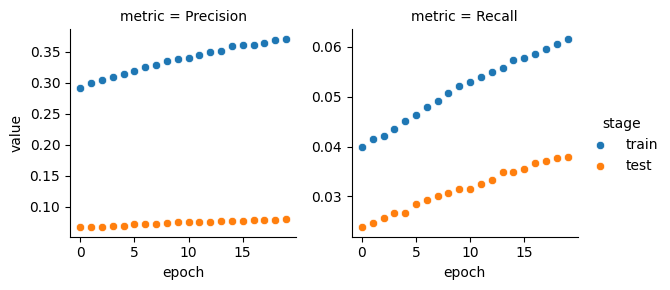

In [39]:
output1, _ = track_model_metrics(model=model1,
                                 train_interactions=train_interactions,
                                 test_interactions=test_interactions,
                                 k=K,
                                 no_epochs=NO_EPOCHS,
                                 no_threads=NO_THREADS)

/usr/local/lib/python3.11/dist-packages/recommenders/models/lightfm/lightfm_utils.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fitting_metrics.metric.replace(metric_keys, inplace=True)


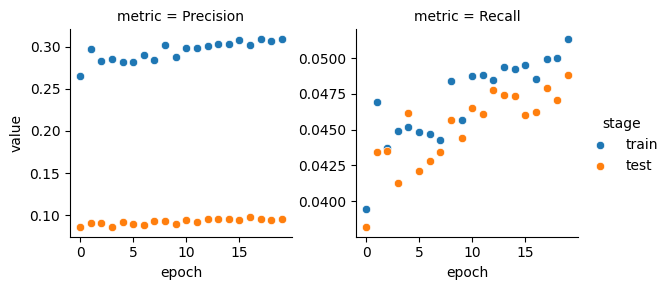

In [40]:
output2, _ = track_model_metrics(model=model2,
                                 train_interactions=train_interactions2,
                                 test_interactions=test_interactions2,
                                 k=K,
                                 no_epochs=NO_EPOCHS,
                                 no_threads=NO_THREADS,
                                 item_features=item_features,
                                 user_features=user_features)

### 4.1 Comparación de desempeño

Se generan visualizaciones para Precision y Recall

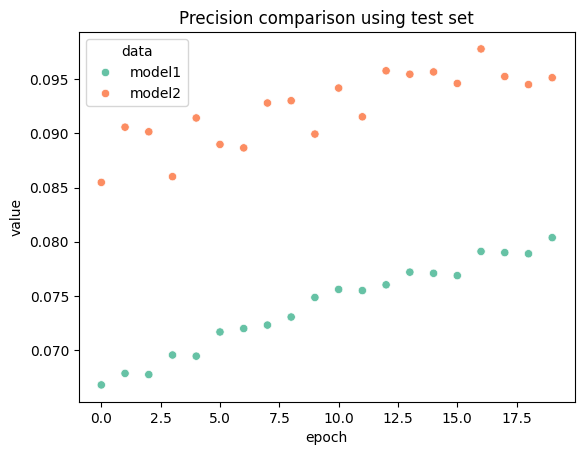

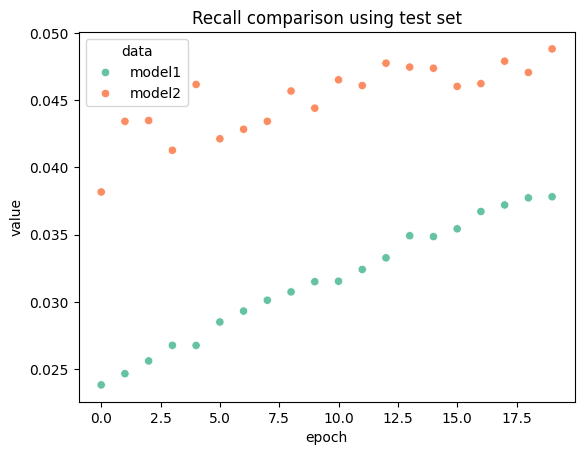

In [41]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch",
                    y="value",
                    hue='data',
                    data=compare_metric(df_list = [output1, output2], metric=i)
                   ).set_title(f'{i} comparison using test set');

¿Qué se puede concluir de estas imágenes?

## Actividad:

### Parte 1 (2ptos):

Explique de qué se trata el modelo LightFM.

*RESPUESTA:*

### Parte 2 (4ptos):

Elija uno de las dos versiones del problema de recomendación (con o sin información adicional para usuarios o ítems) e intente mejorar el desempeño de la recomendación. Para esto, pruebe al menos dos combinaciones de hiperparámetros distintas en el problema elegido. Se debe generar una hipótesis de por qué podría mejorar con dicha combinación de hiperparámetros.

PD: Se asignará puntaje completo tanto si se logra o no mejorar la recomendación. Lo importante es que hagan la experimentación.